This will the notebook used for generating the pseudo masks that will serve as the proxy truth for our flood prediction model.

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Process Images

In [3]:
pre_flood_vv_coherence_df = pd.read_csv('csv/coherence/2018-09-04 VV.csv')
co_flood_vv_coherence_df = pd.read_csv('csv/coherence/2018-09-16 VV.csv')

In [10]:
pre_flood_vh_coherence_df = pd.read_csv('csv/coherence/2018-09-04 VH.csv')
co_flood_vh_coherence_df = pd.read_csv('csv/coherence/2018-09-16 VH.csv')

In [ ]:
# vv_coherence_df = pd.read_csv('csv/coherence/2024-07-22 2024-08-03 VV.csv')
# vh_coherence_df = pd.read_csv('csv/coherence/2024-07-22 2024-08-03 VH.csv')
# vv_intensity_df = pd.read_csv('csv/intensity/2024-07-22 2024-08-03 VV.csv')
# vh_intensity_df = pd.read_csv('csv/intensity/2024-07-22 2024-08-03 VH.csv')

In [5]:
def magnitude_to_decibels_to_grayscale(df):
    df = 20 * np.log10(df)
    db_values = df['data']
    db_min = np.min(db_values)
    db_max = np.max(db_values)
    db_normalized = ((db_values - db_min) / (db_max - db_min)) * 255  # verify this operation
    df['grayscale'] = db_normalized
    return df


def coherence_to_grayscale(df):
    df['grayscale'] = (df['data'].fillna(255) * 255).astype(np.uint8)
    return df

In [6]:
def convert_to_grayscale(df, data_transform_func):
    # func should have the column 'grayscale'
    df = df.copy()
    df = data_transform_func(df)
    lat_values = np.sort(df['lat'].unique())
    lon_values = np.sort(df['lon'].unique())
    grid_shape = (len(lat_values), len(lon_values))
    
    # Create a 2D array (image) filled with grayscale values
    image = np.full(grid_shape, 255, dtype=np.uint8)  # Start with white background
    
    # Map lat/lon to grid indices
    lat_idx = {lat: i for i, lat in enumerate(lat_values)}
    lon_idx = {lon: j for j, lon in enumerate(lon_values)}
    
    # Populate the image array with grayscale values based on correlation
    for _, row in df.iterrows():
        i, j = lat_idx[row['lat']], lon_idx[row['lon']]
        image[i, j] = row['grayscale']
    return image

In [7]:
def produce_image_of_polarization_channels(input_channels, data_transform_func):
    fig, axes = plt.subplots(1, 2)
    for idx, df in enumerate(input_channels):
        image = convert_to_grayscale(df, data_transform_func)
        axes[idx].imshow(image, cmap='gray', origin='lower')
        axes[idx].set_xlabel('Longitude')
        axes[idx].set_ylabel('Latitude')
        axes[idx].set_title('VV' if idx == 0 else 'VH')
        yield image

    fig.suptitle('Monochrome Image based on Correlation')
    plt.tight_layout()
    plt.show()

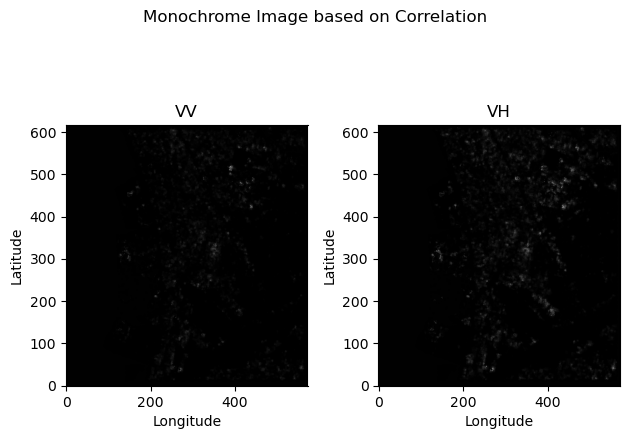

In [8]:
vv_img_pre_flood, vv_img_co_flood = produce_image_of_polarization_channels(
    [pre_flood_vv_coherence_df, co_flood_vv_coherence_df],
    coherence_to_grayscale
)

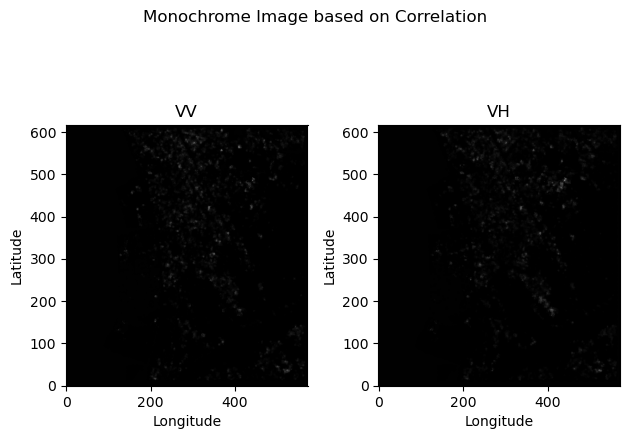

In [11]:
vh_img_pre_flood, vh_img_co_flood = produce_image_of_polarization_channels(
    [pre_flood_vh_coherence_df, co_flood_vh_coherence_df],
    coherence_to_grayscale
)

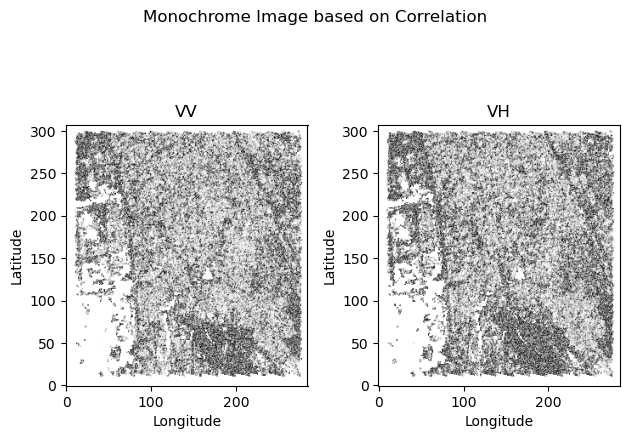

In [14]:
vv_img, vh_img = produce_image_of_polarization_channels(
    [vv_coherence_df, vh_coherence_df],
    coherence_to_grayscale
)

Generate Probabilistic Urban Mask Using Hierarchical Split-based
Approach (HSBA)

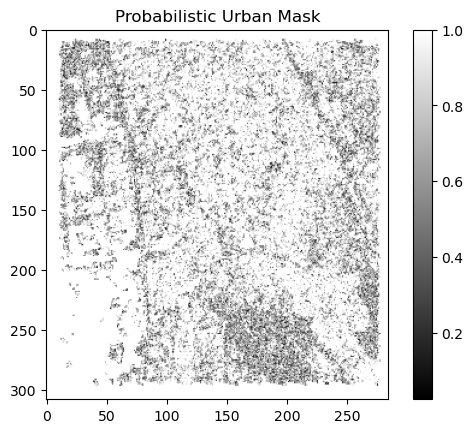

In [51]:
# Function to calculate X1 and X2 thresholds
def calculate_thresholds(image):
    mean = np.mean(image)
    std = np.std(image)
    X1 = mean - 3 * std  # lower threshold
    X2 = mean            # upper threshold
    return X1, X2

# Function to apply S membership function
def s_membership(image, X1, X2):
    mask = np.zeros_like(image, dtype=np.float32)
    mask[image < X1] = 0
    mask[image > X2] = 1
    between_X1_X2 = (image >= X1) & (image <= X2)
    mask[between_X1_X2] = 0.5 * (1 + np.sin(np.pi * (image[between_X1_X2] - X1) / (X2 - X1) - np.pi / 2))
    return mask

# Apply thresholds and S membership to each image
masks = []
for image in [vv_img, vh_img]:
    X1, X2 = calculate_thresholds(image)
    mask = s_membership(image, X1, X2)
    masks.append(mask)

# Combine the masks (e.g., average to create a probabilistic urban mask)
probabilistic_mask = np.flipud(np.mean(masks, axis=0))

# Optional: Display the final mask
plt.imshow(probabilistic_mask, cmap='gray')
plt.colorbar()
plt.title("Probabilistic Urban Mask")
plt.show()

### Image Classifier
The model below will be the CNN model that will be used for classifying our InSAR imagery.

In [2]:
KERNEL_SIZE = 3
POOLING_KERNEL_SIZE = 2
IMAGE_WIDTH =  # TODO: Add
IMAGE_LENGTH =  # TODO: Add

In [ ]:
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Classifier, self).__init__()
        self.layer1 = double_conv_block(2, 16)
        self.max_pool1 = nn.MaxPool2d(kernel_size=POOLING_KERNEL_SIZE)
        self.layer2 = double_conv_blockl(16, 32)
        self.max_pool2 = nn.MaxPool2d(kernel_size=POOLING_KERNEL_SIZE)
        self.layer3 = double_conv_blockl(32, 64)
        self.max_pool2 = nn.MaxPool2d(kernel_size=POOLING_KERNEL_SIZE)

        # TODO: Experiment with No. of Features
        self.fc1 = nn.Linear(in_features=64 * IMAGE_WIDTH * IMAGE_LENGTH, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=2)

    def double_conv_block(self, in_channel_size, out_channel_size)
        block = nn.Sequential(
            nn.Conv2d(in_channels=in_channel_size, out_channels=out_channel_size, kernel_size=KERNEL_SIZE),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channel_size, out_channels=out_channel_size, kernel_size=KERNEL_SIZE),
            nn.ReLU()
        )
        return block
    
    # Progresses data across layers    
    def forward(self, x):
        ...

### Urban Aware Module
Below will be the urban aware attention module.

In [ ]:
REDUCTION_RATIO = 16  # reduction ratio, r of 16 according to CBAM (S. Woo, et al.)

In [ ]:
class UrbanAwareChannelAttentionModule(nn.Module):
    def __init__(self):
        super(CustomChannelAttention, self).__init__()
        in_channels = 2
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Bias
        self.conv1 = nn.Conv2d(in_channels, in_channels // REDUCTION_RATIO, kernel_size=1, bias=False)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels // REDUCTION_RATIO, in_channels, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.global_avg_pool(x)
        out = self.conv1(out)
        out = self.relu(out)
        out = self.conv2(out)
        attention_weights = self.sigmoid(out)
        return x * attention_weights  # intermediate feature

In [ ]:
class UrbanAwareNormalizationModule(nn.Module):
    def __init__(self):
        super(CustomAttentionModule, self).__init__()
        # Bias is omitted according to M. Chini Et Al.
        self.conv = nn.Conv2d(2, 2, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, channel_attention_refined_feature, probalistic_urban_mask):
        # Ws= ReLU(BN(Conv2d(X)))×M
        attention_output = self.relu(self.bn(self.conv(channel_attention_refined_feature))) * probalistic_urban_mask
        final_refined_feature = attention_output * channel_attention_refined_feature
        return final_refined_feature

# Conclusion